In [ ]:
import h5py
import glob
import numpy as np
year = 2001
fn_list = sorted(glob.glob('/storage/coda1/p-rbras6/0/njadidoleslam3/gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/{year}/*/*.HDF5'.format(year = year)))


Error: Session cannot generate requests

In [6]:
data_temp = np.ones((360, 1800, int(len(fn_list)/2)), dtype=np.float16)

In [1]:
# %%timeit 
def read_h5(fn, lon_i):
    try:
        f = h5py.File(fn, 'r')
        dset = f['Grid/precipitationCal'][0,360*lon_i:360*(lon_i+1),:]
        dset[dset==-9999.9] = -99
        return dset.astype(np.float16)
    except:
        return np.ones((360, 1800), dtype=np.float16)* -99

for lon_i in range(0, 10):     # iterating over 5 regions divided by longitude
    data_temp = np.ones((360, 1800, int(len(fn_list)/2)), dtype=np.float16)
    for i in range(int(len(fn_list)/2)):
        fn1 = fn_list[2*i]
        fn2 = fn_list[2*i + 1]
        dset1 = read_h5(fn1, lon_i)
        dset2 = read_h5(fn2, lon_i)
        average = np.array((dset1,dset2)).mean(axis=0)
        data_temp[:, :, i] = average.astype(np.float16)


NameError: name 'np' is not defined

In [6]:
sum((dset1[:,200] + dset2[:,200])/2 == average[:,200]) == len(average[:,200])

True

In [4]:
############## CHECKING DATA SIZE CONSISTENCY FOR ALL YEARS ##############
with open('/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/gpm_analysis/trash/data_len.txt', 'w') as f_log:
        
    for year in range(2001,2021):
        fn_list = sorted(glob.glob('/storage/coda1/p-rbras6/0/njadidoleslam3/gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/{year}/*/*.HDF5'.format(year = year)))
        print(int(len(fn_list)/2))
        f_log.write('{year}, {len}, {odd_even} \n'.format(year = year , len = len(fn_list), odd_even = len(fn_list) %2 == 0))
f_log.close()
############## OK ##############

8760
8760
8760
8784
8760
8760
8760
8784
8760
8760
8760
8784
8760
8760
8760
8784
8760
8760
8760
8784


In [5]:
np.array([99]).astype(np.float16) < 65535

array([ True])

In [7]:
print('Size of data with 100 timestamps: {:.2f}'.format(data_temp.nbytes/1024**3) , 'GB')
print('Size of final data: {:.2f}'.format(data_temp.nbytes/(1024**3)) , 'GB')

Size of data with 100 timestamps: 10.60 GB
Size of final data: 10.60 GB


In [13]:
a = np.random.normal(size = (360,1800,9000))

In [ ]:
a.nbytes/1024**3

array([ 360.37434185, 1800.23017455, 8998.73822473])

# test performance with GDAL and chunks of the array

In [68]:
from osgeo import gdal
import glob
import numpy as np
year = 2001
fn_list = sorted(glob.glob('/storage/coda1/p-rbras6/0/njadidoleslam3/gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/{year}/*/*.HDF5'.format(year = year)))

fn_temp = 'HDF5:"{fn}"://Grid/precipitationCal'

In [69]:
# %%timeit
for lon_i in range(0, 5):     # iterating over 3600 elements
    
    data_temp = np.ones((360, 1800, len(fn_list[0:100])), dtype=np.int16)
    for i, fn in enumerate(fn_list[0:100]):
        fn_in = fn_temp.format(fn = fn)
        f = gdal.Open(fn_in)
        dset = f.ReadAsArray()[360*lon_i:360*(lon_i+1),:]
        dset[dset==-9999.9] = -99
        data_temp[:, :, i] = dset.astype(np.int16)

In [62]:
print('Size of data with 100 timestamps: {:.2f}'.format(data_temp.nbytes/1024**3) , 'GB')
print('Size of final data: {:.2f}'.format(data_temp.nbytes/(1024**3)*len(fn_list)/100) , 'GB')

Size of data with 100 timestamps: 0.12 GB
Size of final data: 21.15 GB


# test performance without chunk

In [70]:
# %%timeit
fn_temp = 'HDF5:"{fn}"://Grid/precipitationCal'
for lon_i in range(0, 1):     # iterating over 3600 elements
    
    data_temp = np.ones((3600, 1800, len(fn_list[0:100])), dtype=np.float16)
    for i, fn in enumerate(fn_list[0:100]):
        fn_in = fn_temp.format(fn = fn)
        f = gdal.Open(fn_in)
        dset = f.ReadAsArray()
        dset[dset==-9999.9] = -99
        # dset = dset*100
        data_temp[:, :, i] = dset.astype(np.float16)

In [74]:
print('Size of final data: {:.2f}'.format(data_temp.nbytes/1024**3*len(fn_list)/100) , 'GB')

Size of final data: 211.47 GB


# Test result:

## Only difference is the 

In [75]:
import xarray as xar

In [76]:

drop_vars =  [
    'time_bnds',
 'lon_bnds',
 'lat_bnds',
 'precipitationUncal',
 'randomError',
 'HQprecipitation',
 'HQprecipSource',
 'HQobservationTime',
 'IRprecipitation',
 'IRkalmanFilterWeight',
 'probabilityLiquidPrecipitation',
 'precipitationQualityIndex']
dset = xar.open_mfdataset(fn_list[:100], parallel = False, group='Grid', data_vars='minimal', drop_variables=drop_vars, concat_dim=['time'], coords=['time'], combine='by_coords')

In [77]:
aa = dset.load()

In [81]:
aa.nbytes/1024**3*len(fn_list)/100

422.93437242507935

In [78]:
aa['precipitationCal'][:,0,0]

<xarray.DataArray 'precipitationCal' (time: 100)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) object 2001-01-01 00:00:00 ... 2001-01-03 01:30:00
    lon      float32 -179.9
    lat      float32 -89.95
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9

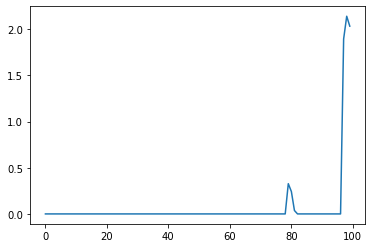

In [47]:
import matplotlib.pyplot as plt
# plt.plot(dset[:,0])
plt.plot(data_temp[340,500,:])

In [40]:
fn_in = fn_temp.format(fn = fn_list[10000])
f = gdal.Open(fn_in)
%timeit dset = f.ReadAsArray()[:,0:180]
%timeit dset = f.ReadAsArray()[0:145, :]



4.26 ms ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.53 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# lon, lat =np.meshgrid(lon,lat)

fig, ax = plt.subplots(figsize=(20,10))
a = ax.imshow(data1[:, :, i], vmin=0, vmax = 500, cmap=plt.cm.Blues)
cax = plt.axes([0.92, 0.25, 0.02, 0.5])
plt.colorbar(a, cax=cax)

In [1]:
import pickle
import numpy as np
import os
import sys

# Reorganize data by month
def read_pickle(fn):
    data_test = []
    with open(fn, 'rb') as handle:
        try:
            while True:
                data_test.append(pickle.load(handle))
        except EOFError:
            pass
    return data_test

year = 2012
in_pick_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/gpm/events/yearly/{year}.pickle'
in_pickle = in_pick_fmt.format(year = year)
data_test = read_pickle(in_pickle)

KeyboardInterrupt: 

In [1]:
import pickle
import numpy as np
import pandas as pd
import sys
import os


# def read_pickle(fn):
#     data_test = []
#     with open(fn, 'rb') as handle:
#         try:
#             while True:
#                 data_test.append(pickle.load(handle))
#                 data_all = pd.DataFrame(data_all, columns=['grid_xy','year', 'month','tr', 'i', 'tb'])
#                 data_all['h'] = data_all['i'] * data_all['tr']
#         except EOFError:
#             pass
#     return data_test


month = 2

pickle_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/gpm/events/monthly/{month}.pickle'
pickle_out_fmt =  '/storage/coda1/p-rbras6/0/njadidoleslam3/gpm/events/summary/{month}.pickle'


in_pickle = pickle_fmt.format(month = month)
fn_out_pickle = pickle_out_fmt.format(month = month)
with open(fn_out_pickle, 'wb') as handle_out:
    with open(in_pickle, 'rb') as handle:
        try:
            while True:
                data_all = pickle.load(handle)

                events_all = pd.DataFrame(data_all, columns=['grid_xy','year', 'month','tr', 'i', 'tb'])
                events_all['h'] = events_all['i'] * events_all['tr']
                ######### Aggregations #########
                summary = events_all.groupby('grid_xy').mean().reset_index()       # mean
                summary_std = events_all.groupby('grid_xy').std().reset_index()          # standard deviation 
                counts = events_all.groupby('grid_xy').count().reset_index()            # count

                ##########
                summary['CV'] = summary_std['tb']/summary['tb']
                summary['lambda'] = summary['h']/np.power(summary_std['h'],2)
                summary['kappa'] = summary['h'] * summary['lambda']
                summary['count'] = counts['tr']
                pickle.dump(summary, handle_out, protocol= pickle.HIGHEST_PROTOCOL) 
        except EOFError:
            pass

In [4]:
import pickle
import numpy as np
import pandas as pd
import sys
import os

fn_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/gpm/events/summary/{month}.pickle'
def read_pickle(fn):
    data_test = []
    with open(fn, 'rb') as handle:
        try:
            while True:
                data_test.append(pickle.load(handle))
        except EOFError:
            pass
    return data_test
month = 2
fn = fn_fmt.format(month = month)
data = read_pickle(fn)
columns = {'grid_xy':np.int32,	'year':np.int32,	'month':np.int32,	'tr':np.float32,	'i':np.float32,	'tb':np.float32,	'h':np.float32,	'CV':np.float32,	'lambda':np.float32,	'kappa':np.float32,	'count':np.float32}
summary = pd.DataFrame(columns = columns)
summary.astype(columns)
for item in data:
     summary = summary.append(item, ignore_index=True)

summary = summary.astype(columns)
summary_mean = summary.groupby('grid_xy').mean().reset_index()
pickle_out_fmt =  '/storage/coda1/p-rbras6/0/njadidoleslam3/gpm/events/summary_mean/{month}.pickle'
fn_out_pickle = pickle_out_fmt.format(month = month)
with open(fn_out_pickle, 'wb') as handle_out:
     pickle.dump(summary_mean, handle_out, protocol= pickle.HIGHEST_PROTOCOL)


In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
# points = gpd.read_file('points.shp')

xmin, ymin, xmax, ymax = [-180, -90, 180, 90]

length = 0.1
wide = 0.1

cols = list(np.arange(xmin, xmax, 0.1))
rows = list(np.arange(ymin, ymax, 0.1))

polygons = []
for x in cols:
    for y in rows:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid_x, grid_y = np.meshgrid(np.arange(3600),np.arange(1800))
grid_xy = grid_x*10**4 + (1799-grid_y) + 10**8
grid_xy = grid_xy.ravel()

grid = gpd.GeoDataFrame({'geometry':polygons, 'grid_xy':grid_xy})

In [3]:
grid = grid.set_crs(epsg=4326)

In [4]:
grid.to_file('/storage/home/hcoda1/6/njadidoleslam3/p-rbras6-0/projects/stochsm/data/gis_files/gpm/global_gpm_grid_w_grid_xy.shp')

In [7]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from datetime import datetime
import geopandas as gpd
def read_pickle(fn):
    data_test = []
    with open(fn, 'rb') as handle:
        try:
            while True:
                data_test.append(pickle.load(handle))
        except EOFError:
            pass
    return data_test

fn = '/storage/coda1/p-rbras6/0/njadidoleslam3/gpm/events/summary_mean/1.pickle'
summary_mean = read_pickle(fn)
summary_mean = summary_mean[0]

var_list = {
    'tr':       {'max':48, 'min':0, 'label': 'Mean Event Duration [$hr$]', 'bw':6,'nbins':8, 'cmap':'Blues' },
    'i':        {'max':5, 'min':0, 'label': 'Mean Intensity [$mm/hr$]', 'bw':1,'nbins':10,'cmap':'Blues'},
    'tb':       {'max':360, 'min':0, 'label': 'Mean Interarrival Time [$hr$]', 'bw':12, 'nbins':15, 'cmap':'Reds'},
    'h':        {'max':23, 'min':3, 'label': 'Mean Storm Depth [$mm$]', 'bw':3,'nbins':20, 'cmap':'Blues'},
    'count':    {'max':15, 'min':0, 'label': 'Mean Number of Events', 'bw':1,'nbins':15, 'cmap':'Blues'},
    'CV':       {'max':1.2, 'min':0.80, 'label': 'Coef. Var.', 'bw':0.05,'nbins':8, 'cmap':'RdBu'}
    }

summary_mean['grid_xy'] = summary_mean['grid_xy'].astype(np.int64)




In [42]:
summary_mean

,grid_xy,year,month,tr,i,tb,h,CV,lambda,kappa,count
0,100000117,2019.500000,1.0,22.577381,0.128969,59.946426,4.741447,0.871064,2.024376,0.603758,9.500000
1,100000118,2019.500000,1.0,7.090909,0.210707,39.416664,2.665082,1.044659,0.524114,0.205957,17.000000
2,100000119,2019.500000,1.0,9.235087,0.183803,34.731579,3.904016,0.947501,0.406499,0.227822,17.000000
3,100000120,2010.263158,1.0,35.020424,0.151355,74.858231,2.875587,1.028525,0.317704,0.354585,11.947369
4,100000121,2010.526316,1.0,21.437399,0.170464,52.966961,2.727391,0.984654,0.534763,1.089732,18.736841
...,...,...,...,...,...,...,...,...,...,...,...
4928239,135991544,2018.000000,1.0,10.500000,0.186509,116.500000,1.459961,1.232126,4.401888,6.426585,2.000000
4928240,135991545,2011.000000,1.0,3.500000,0.088175,377.500000,0.398684,1.192147,2.344912,1.866598,1.500000
4928241,135991546,2017.000000,1.0,1.000000,0.014999,19.000000,0.014999,NaN,NaN,NaN,1.000000
4928242,135991548,2017.000000,1.0,1.000000,0.027191,19.000000,0.027191,NaN,NaN,NaN,1.000000


In [33]:
aaa = np.ones((3600,1800))*np.nan


In [38]:
aaa[1900,1000]

nan

In [51]:
summary_mean

,grid_xy,year,month,tr,i,tb,h,CV,lambda,kappa,count
0,100000117,2019.500000,1.0,22.577381,0.128969,59.946426,4.741447,0.871064,2.024376,0.603758,9.500000
1,100000118,2019.500000,1.0,7.090909,0.210707,39.416664,2.665082,1.044659,0.524114,0.205957,17.000000
2,100000119,2019.500000,1.0,9.235087,0.183803,34.731579,3.904016,0.947501,0.406499,0.227822,17.000000
3,100000120,2010.263158,1.0,35.020424,0.151355,74.858231,2.875587,1.028525,0.317704,0.354585,11.947369
4,100000121,2010.526316,1.0,21.437399,0.170464,52.966961,2.727391,0.984654,0.534763,1.089732,18.736841
...,...,...,...,...,...,...,...,...,...,...,...
4928239,135991544,2018.000000,1.0,10.500000,0.186509,116.500000,1.459961,1.232126,4.401888,6.426585,2.000000
4928240,135991545,2011.000000,1.0,3.500000,0.088175,377.500000,0.398684,1.192147,2.344912,1.866598,1.500000
4928241,135991546,2017.000000,1.0,1.000000,0.014999,19.000000,0.014999,NaN,NaN,NaN,1.000000
4928242,135991548,2017.000000,1.0,1.000000,0.027191,19.000000,0.027191,NaN,NaN,NaN,1.000000


In [62]:

data = dict()
for var in list(var_list.keys()):
        data[var] = np.ones((3600,1800))*np.nan

for item in summary_mean.iterrows():    
    grid_y = int(item[1]['grid_xy'] % 10000)
    grid_x = int((item[1]['grid_xy'] - grid_y)/ 10000 % 10000)

    for var in list(var_list.keys()):
        data[var][grid_x, grid_y] = item[1][var]
        
    
    

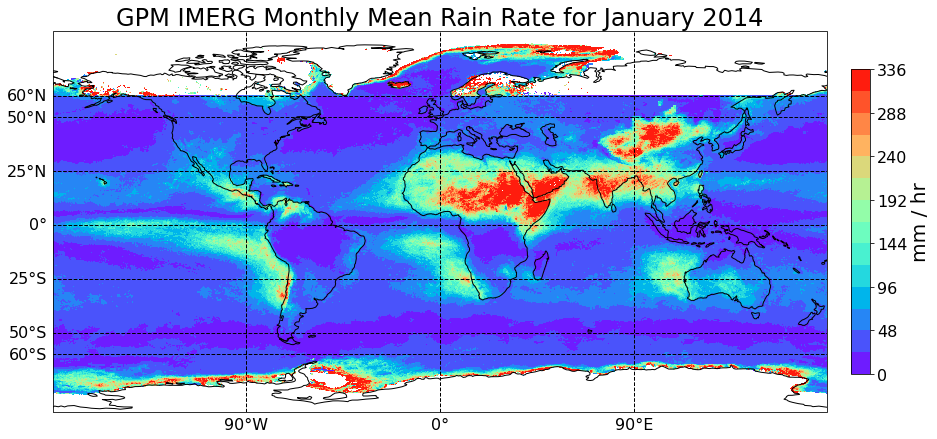

In [66]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import glob
fn_list = sorted(
    glob.glob(
    '/storage/coda1/p-rbras6/0/njadidoleslam3/gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/{year}/*/*.HDF5'.format(year=2002)
            )
        )
fn = fn_list[0]
f = h5py.File(fn, 'r')
precip = data['tb']
precip = np.transpose(precip)
theLats = f['Grid/lat'][:]
theLons = f['Grid/lon'][:]
x, y = np.float32(np.meshgrid(theLons, theLats))
 

# Plot the data using matplotlib and cartopy

# Set the figure size, projection, and extent
fig = plt.figure(figsize=(21,7))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-180,180,-60,60])  

# Add coastlines and formatted gridlines
ax.coastlines(resolution="110m",linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':16, 'color':'black'}
gl.ylabel_style = {'size':16, 'color':'black'}

# Set contour levels and draw the plot
clevs = np.arange(0,360,24)
plt.contourf(x, y, precip, clevs, cmap=plt.cm.rainbow)
plt.title('GPM IMERG Monthly Mean Rain Rate for January 2014', size=24)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('mm / hr',size=20)
cb.ax.tick_params(labelsize=16)

# Save the figure as a PNG:

fig.savefig('GPM_3IMERGP_plot.png', bbox_inches='tight', pad_inches = 0.1)



In [ ]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from datetime import datetime
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def read_pickle(fn):
    data_test = []
    with open(fn, 'rb') as handle:
        try:
            while True:
                data_test.append(pickle.load(handle))
        except EOFError:
            pass
    return data_test


var_list = {
    'tr':       {'max':48, 'min':0, 'label': 'Mean Event Duration [$hr$]', 'bw':6,'nbins':8, 'cmap':'Blues' },
    'i':        {'max':5, 'min':0, 'label': 'Mean Intensity [$mm/hr$]', 'bw':1,'nbins':10,'cmap':'Blues'},
    'tb':       {'max':360, 'min':0, 'label': 'Mean Interarrival Time [$hr$]', 'bw':12, 'nbins':15, 'cmap':'Reds'},
    'h':        {'max':23, 'min':3, 'label': 'Mean Storm Depth [$mm$]', 'bw':3,'nbins':20, 'cmap':'Blues'},
    'count':    {'max':15, 'min':0, 'label': 'Mean Number of Events', 'bw':1,'nbins':15, 'cmap':'Blues'},
    'CV':       {'max':1.2, 'min':0.80, 'label': 'Coef. Var.', 'bw':0.05,'nbins':8, 'cmap':'RdBu'}
    }

# month = int(sys.argv[1])
month = 2

fn_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/gpm/events/summary_mean/{month}.pickle'
fn = fn_fmt.format(month = month)
summary_mean = read_pickle(fn)
summary_mean = summary_mean[0]

data = dict()
for var in list(var_list.keys()):
        data[var] = np.ones((3600,1800))*np.nan

for item in summary_mean.iterrows():    
    grid_y = int(item[1]['grid_xy'] % 10000)
    grid_x = int((item[1]['grid_xy'] - grid_y)/ 10000 % 10000)

    for var in list(var_list.keys()):
        data[var][grid_x, grid_y] = item[1][var]



In [15]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from datetime import datetime
# import geopandas as gpd
import numpy as np
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import glob

def read_pickle(fn):
    data_test = []
    with open(fn, 'rb') as handle:
        try:
            while True:
                data_test.append(pickle.load(handle))
        except EOFError:
            pass
    return data_test


var_list = {
    'tr':       {'max':48, 'min':0, 'label': 'Mean Event Duration [$hr$]', 'bw':6,'nbins':8, 'cmap':'Blues' },
    'i':        {'max':5, 'min':0, 'label': 'Mean Intensity [$mm/hr$]', 'bw':1,'nbins':10,'cmap':'Blues'},
    'tb':       {'max':360, 'min':0, 'label': 'Mean Interarrival Time [$hr$]', 'bw':12, 'nbins':15, 'cmap':'Reds'},
    'h':        {'max':23, 'min':3, 'label': 'Mean Storm Depth [$mm$]', 'bw':3,'nbins':20, 'cmap':'Blues'},
    'count':    {'max':15, 'min':0, 'label': 'Mean Number of Events', 'bw':1,'nbins':15, 'cmap':'Blues'},
    'CV':       {'max':1.2, 'min':0.80, 'label': 'Coef. Var.', 'bw':0.05,'nbins':8, 'cmap':'RdBu'}
    }

# month = int(sys.argv[1])
month = 2

fn_fmt = '/home/navid/projects/stochsm/summary_mean/{month}.pickle'
fn = fn_fmt.format(month = month)
summary_mean = read_pickle(fn)
summary_mean = summary_mean[0]

data = dict()
for var in list(var_list.keys()):
        data[var] = np.ones((3600,1800))*np.nan

for item in summary_mean.iterrows():    
    grid_y = int(item[1]['grid_xy'] % 10000)
    grid_x = int((item[1]['grid_xy'] - grid_y)/ 10000 % 10000)

    for var in list(var_list.keys()):
        data[var][grid_x, grid_y] = item[1][var]


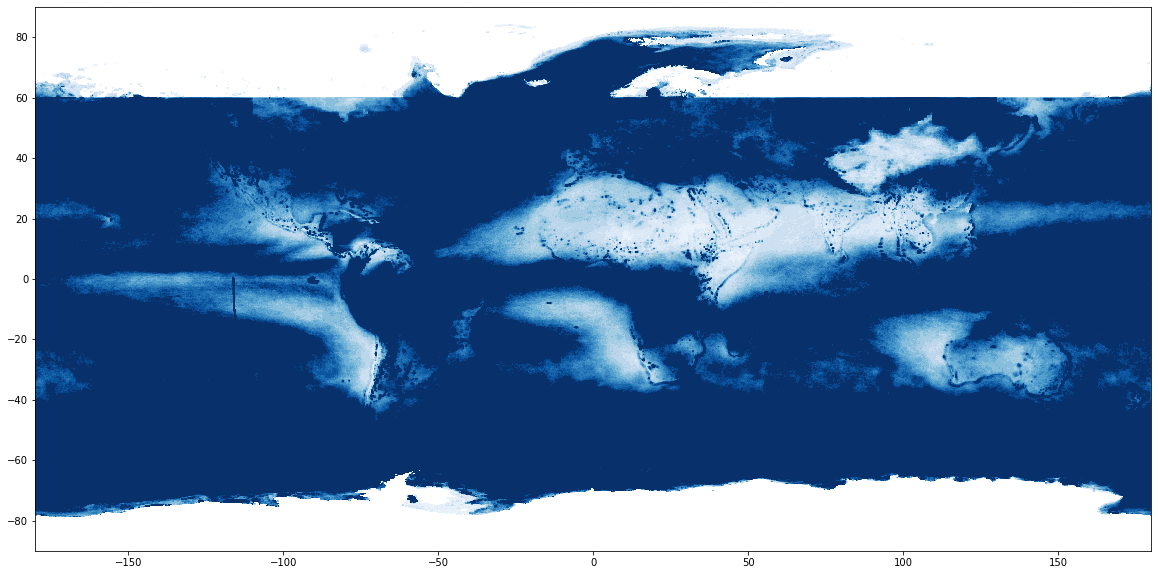

In [33]:
variable = 'count'
cm1 = plt.cm.get_cmap(var_list[variable]['cmap'],var_list[variable]['nbins']-0)
fn = '/home/navid/projects/stochsm/trash/3B-HHR.MS.MRG.3IMERG.20000606-S000000-E002959.0000.V06B.HDF5'
f = h5py.File(fn, 'r')
theLats = f['Grid/lat'][:]
theLons = f['Grid/lon'][:]
x, y = np.float32(np.meshgrid(theLons, theLats))
x_d = np.linspace(var_list[variable]['min'], var_list[variable]['max'], var_list[variable]['nbins']+1)
fig,ax = plt.subplots(figsize=(20,10))
ax.contourf(x, y, np.transpose(data[variable]), x_d, cmap=cm1,  extend="both")
# ax.imshow(np.flipud(np.transpose(data[variable])), cmap=cm1)

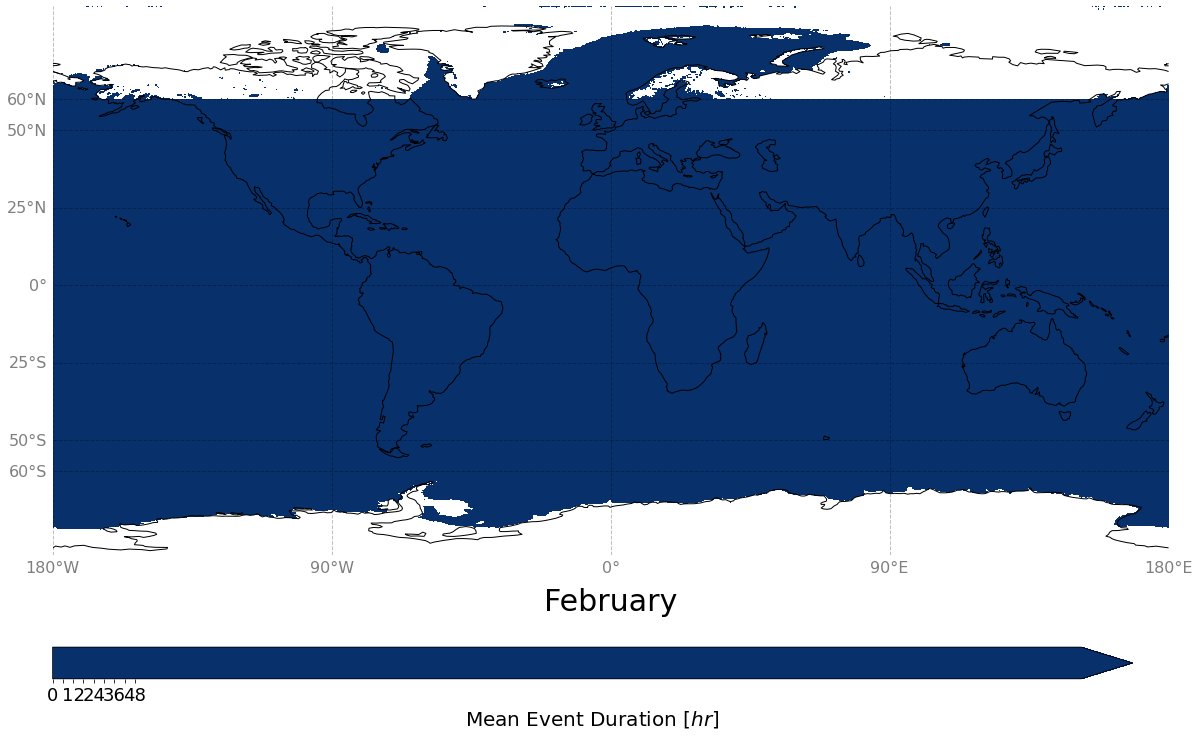

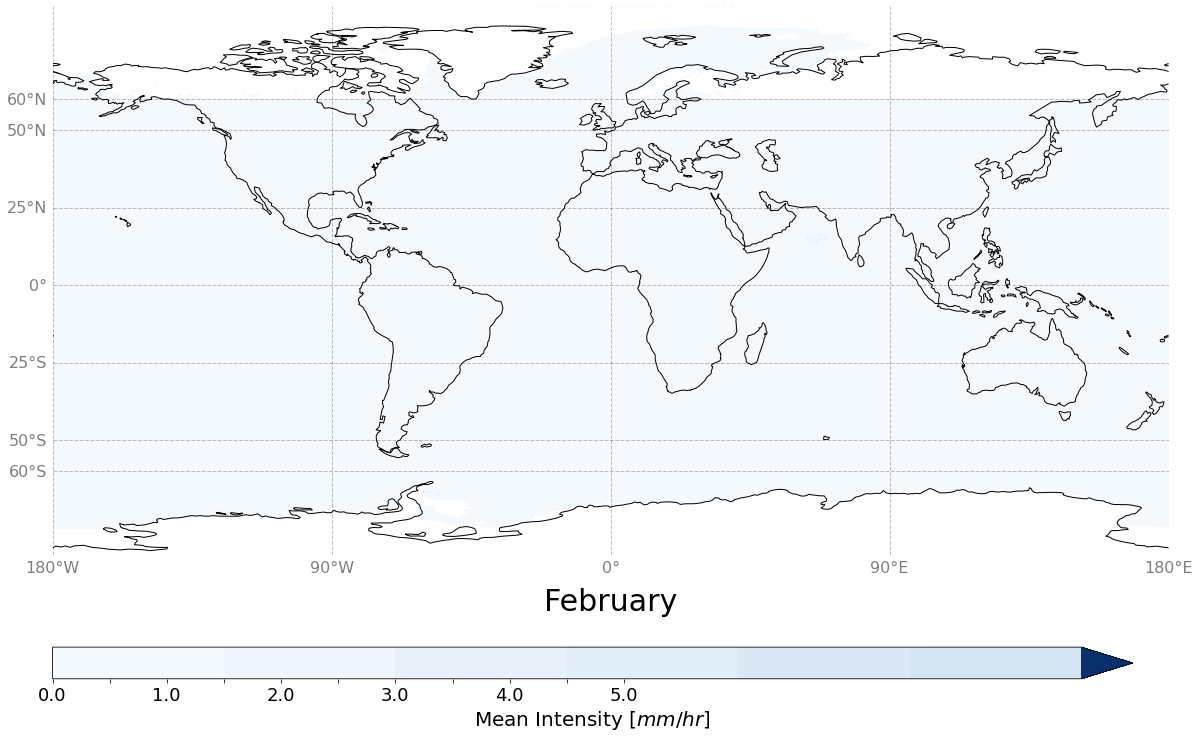

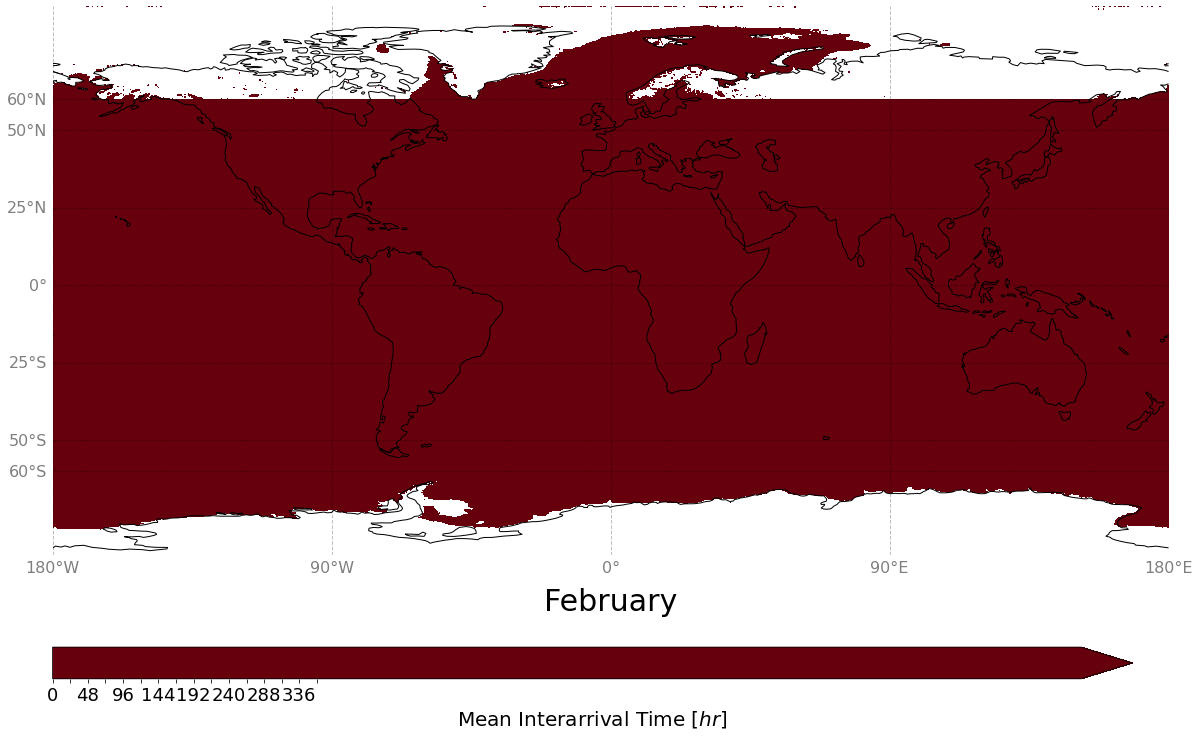

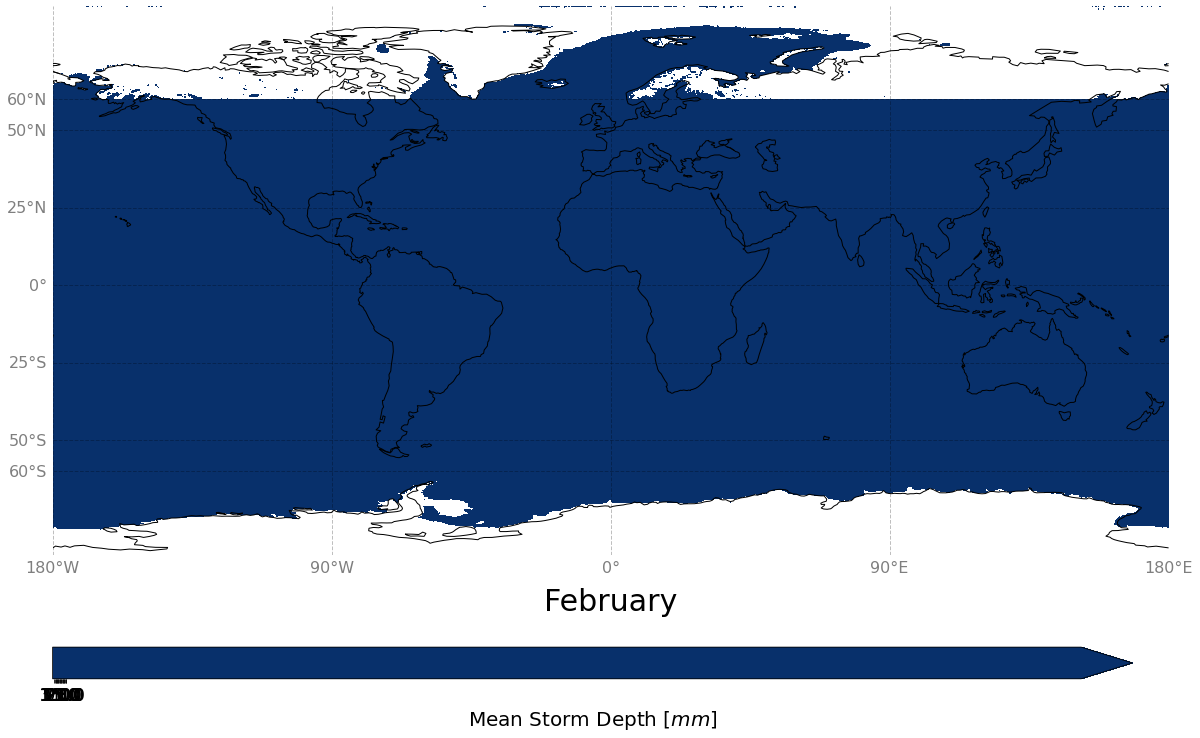

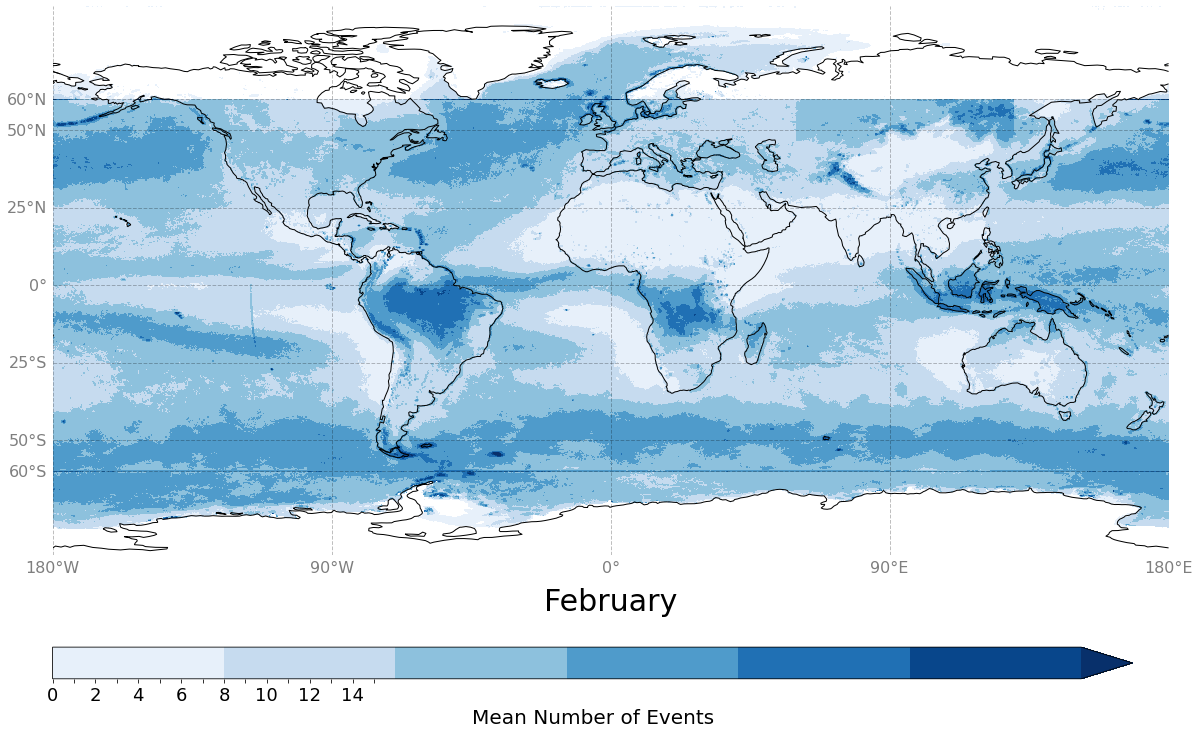

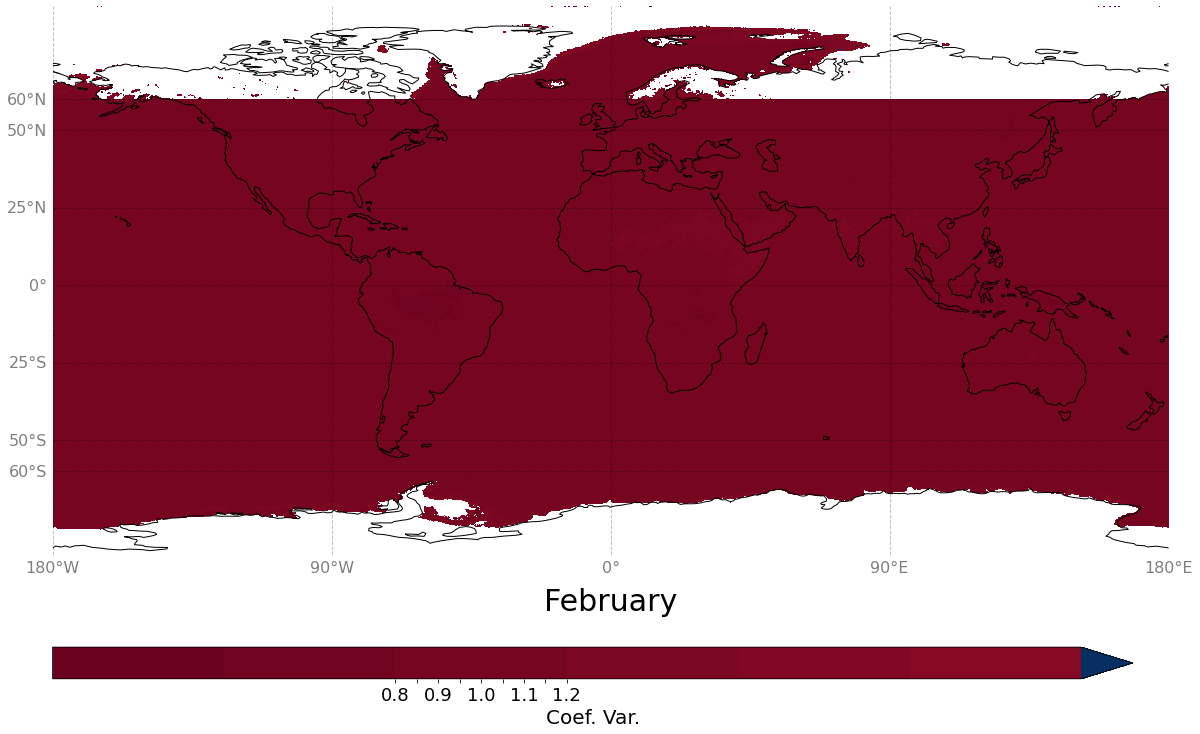

In [49]:
fn = '/home/navid/projects/stochsm/trash/3B-HHR.MS.MRG.3IMERG.20000606-S000000-E002959.0000.V06B.HDF5'
f = h5py.File(fn, 'r')
theLats = f['Grid/lat'][:]
theLons = f['Grid/lon'][:]
x, y = np.float32(np.meshgrid(theLons, theLats))


for variable in list(var_list.keys()):
    out_pth = '/home/navid/projects/stochsm/figures/gpm/summary/{variable}/'.format(variable = variable)
    out_fn = '{variable}_{month}.jpg'.format(variable = variable, month=month)

    if not os.path.exists(out_pth):
        os.makedirs(out_pth)

    precip = data[variable]
    precip = np.transpose(precip)

    
    cm1 = plt.cm.get_cmap(var_list[variable]['cmap'])#,var_list[variable]['nbins']-0)
    # fig, ax = plt.subplots(figsize=(20, 16))

    fig = plt.figure(figsize=(20,11))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ax.set_extent([-180,180,-60,60])  

    # Add coastlines and formatted gridlines
    ax.coastlines(resolution="110m",linewidth=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='black', alpha = 0.25, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
    gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size':16, 'color':'black', 'alpha' : 0.5}
    gl.ylabel_style = {'size':16, 'color':'black', 'alpha' : 0.5}

    # Set contour levels and draw the plot
    # clevs = np.arange(var_list[variable]['min'], var_list[variable]['max'] + var_list[variable]['max']/var_list[variable]['nbins'],var_list[variable]['max']/var_list[variable]['nbins'])
    x_d = np.linspace(var_list[variable]['min'], var_list[variable]['max'], var_list[variable]['nbins']+1)
    
    labels = []
    for i,x1 in enumerate(x_d):
        if i%2==0:
            if variable in ['tb', 'tr', 'count']:
                labels.append(str(int(x1)))
            else:
                labels.append(str(x1))
        else:
            labels.append('')
    a = ax.contourf(x, y, precip, vmin=0, vmax = 48, cmap=cm1,  extend="max")

    
    ax.set_axis_off()
    dt_str = '2020-{month}-1'.format(month = month)
    mnth_name = pd.to_datetime(dt_str).month_name()
    ax.set_xlim([-180, 180])
    # ax.set_ylim([-60, 60])

    ax.text(0.44,-0.1, mnth_name,transform=ax.transAxes, fontsize=30)
    cax = fig.add_axes([0.125, 0.0, 0.75, 0.04])
    fig.colorbar(a, cax=cax, orientation='horizontal')
    cax.set_xlabel(var_list[variable]['label'], fontsize=20)

    cax.tick_params(labelsize=18)
    cax.xaxis.set_major_locator(ticker.FixedLocator(x_d))
    cax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    fn_out = os.path.join(out_pth,out_fn)
    # fig.savefig(fn_out, dpi=300, bbox_inches='tight')
    # plt.close(fig)

In [46]:
fn_out

'/home/navid/projects/stochsm/figures/gpm/summary/tb/tb_2.jpg'